In [24]:
# ===================================================================
#  Library
# ===================================================================
import os
import glob
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error

import multiprocessing

import warnings
warnings.simplefilter("ignore")

from tqdm.auto import tqdm
import optuna
import unicodedata

import lightgbm as lgb

In [25]:
# ===================================================================
#  CFG
# ===================================================================
class CFG:
    filename = "expXXX"
    seed = 42
    n_splits = 5
    data_dir = "G:/マイドライブ/signate_StudentCup2023/data/"
    year_bins = 20
    num_boost_round = 10000
    stopping_rounds = 1500
    n_trials = 1500
    save_dir = "G:/マイドライブ/signate_StudentCup2023/exp/"
    num_cores = multiprocessing.cpu_count()
    categorical_features = [
        "fuel", "title_status", "type", "state", "region", "manufacturer", "condition", "cylinders", "transmission", "drive", "size", "paint_color"
        ]

In [26]:
# ===================================================================
#  Utils
# ===================================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(CFG.seed)
    

def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100

In [27]:
# ===================================================================
#  Data Loading
# ===================================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")
oof_df = pd.read_csv(CFG.save_dir+"exp008_oof_df.csv")[["id", "pred"]].rename(columns={"pred":"pred_1"})
train = pd.merge(train, oof_df, on="id", how="left")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)

In [28]:
# ===================================================================
#  preprocessing
# ===================================================================
def preprocessing(all_data: pd.DataFrame):
    """
    train, testデータで共通の前処理のコード
    
    ・yearの異常値を直す
    ・manufacturerの表記を統一する
    ・sizeの表記を統一する
    ・regionの欠損値をtrain dataの(state, region)の組み合わせから補完する。残った欠損値は調べて補完する。
    ・title_statusとtypeの欠損値処理はとりあえず放置

    Args:
        all_data (pd.DataFrame): pd.concat([train, test], ignore_index=True)
    """
    # year
    year_dict = {
        2999:1999,
        3008:2008,
        3011:2011,
        3015:2015,
        3017:2017,
        3019:2019,
    }
    all_data["year"] = all_data["year"].replace(year_dict)
    
    
    # manufacturer
    all_data["manufacturer"] = all_data["manufacturer"].str.lower().apply(lambda x: unicodedata.normalize('NFKC', x))
    manufacturer_map = {
        'niѕsan':'nissan',
        'nisѕan':'nissan',
        'subαru':'subaru',
        'toyotа':'toyota',
        'sαturn':'saturn',
        'аcura':'acura',
        'vоlkswagen':'volkswagen',
        'lexuѕ':'lexus',
        'ᴄhrysler':'chrysler',
    }
    all_data["manufacturer"] = all_data["manufacturer"].replace(manufacturer_map)
    
    
    # size
    size_dict = {
        "fullーsize":"full-size",
        "midーsize":"mid-size",
        "subーcompact":"sub-compact",
        "full−size":"full-size",
        "mid−size":"mid-size"
    }
    all_data["size"] = all_data["size"].replace(size_dict)
        
    
    # 地域
    ## region -> stateが一意に定まることを確認
    region_state = {region:{} for region in all_data[all_data["flag"]=="train"]['region'].unique()}
    for row, value in all_data[all_data["flag"]=="train"].iterrows():
        if not pd.isna(value['state']):
            if value['state'] not in region_state[value['region']]:
                region_state[value['region']][value['state']] = 1
            else:
                region_state[value['region']][value['state']] += 1
    for region, state_dict in region_state.items():
        if len(state_dict) > 1 or state_dict == {}:
            region_state[region] = pd.NA
        else:
            region_state[region] = list(state_dict.keys())[0]

    ## regionからstateを決定
    all_data['state'] = [region_state[region] if pd.isna(state) else state for region, state in zip(all_data['region'], all_data['state'])]
    all_data.loc[all_data["region"] == "northwest KS", "state"] = "ks"
    all_data.loc[all_data["region"] == "ashtabula", "state"] = "oh"
    all_data.loc[all_data["region"] == "southern WV", "state"] = "wv"
    
    # type
    ## 欠損値 train: 456, test: 229
    
    # title_status
    ## 欠損値 train: 456, test: 229
    
    # fuel
    ## 欠損値 train: 1239, test: 1495
    
    return all_data
all_data = preprocessing(all_data)

In [29]:
# ===================================================================
#  Cross Validation
# ===================================================================
train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)

train.sort_values(by="id", ignore_index=True, inplace=True)

train["year_map"], bins = pd.cut(train["year"], bins=20, labels=False, retbins=True)
test["year_map"] = pd.cut(test["year"], bins=bins, labels=False)


# priceを小さい順に各foldに振り分ける
train.sort_values(by="price", ignore_index=True, inplace=True)
train["fold"] = [col for col in range(CFG.n_splits)] * (train.shape[0]//CFG.n_splits) \
                + [col for col in range(0, train.shape[0] - len([col for col in range(CFG.n_splits)] * (train.shape[0] //CFG.n_splits)))]
train.sort_values(by="id", ignore_index=True, inplace=True)
print("The variance of the mean of the folds: ", train.groupby("fold")["price"].mean().std())

The variance of the mean of the folds:  4.695908800203918


In [30]:
def preprocessing_per_fold(CFG, train:pd.DataFrame, test:pd.DataFrame = None, fold:int = 0, predict:bool = False):
    """foldごとの前処理: leakageを防ぐ

    Args:
        CFG :config
        train (pd.DataFrame): 学習データ
        test (pd.DataFrame, optional): test data Defaults to None.
        fold (int, optional): Defaults to 0.
        predict (bool, optional): 予測するか否か. Defaults to False.
    """
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_valid = train[train["fold"] == fold].reset_index(drop=True)    
    if predict:
        test_df = test.copy()

    # odometerの補正
    ## odometerが100以下or400000以上を異常値と考えて補完する
    ## year_mapがodometerの分散が大きくなる特徴量だったのでこれを利用してodometerを補完する
    fillna_map = X_train[(X_train["odometer"] > 100)&(X_train["odometer"] < 400000)].groupby(["year_map"])["odometer"].mean().reset_index()
    
    def replace_odometer(df: pd.DataFrame, fillna_map: pd.DataFrame)-> pd.DataFrame:
        """odometerの異常値をfillna_mapを利用して補完する

        Args:
            df (pd.DataFrame): 補完前のデータ
            fillna_map (pd.DataFrame): 補完するデータ

        Returns:
            pd.DataFrame: 補完後のデータ
        """
        df_1 = df[(df["odometer"] < 100)|(df["odometer"] > 400000)].reset_index(drop=True)
        df_2 = df[(df["odometer"] >= 100)&(df["odometer"] <= 400000)].reset_index(drop=True)
        df_1.drop("odometer", inplace=True, axis=1)
        df_1 = pd.merge(df_1, fillna_map, on="year_map", how="left")
        df = pd.concat([df_1, df_2])
        return df.sort_values("id", ignore_index=True)
    
    
    X_train = replace_odometer(X_train, fillna_map)
    X_valid = replace_odometer(X_valid, fillna_map)
    if predict:
        test_df = replace_odometer(test_df, fillna_map)
        
        
    # カウントエンコーディング
    for col in CFG.categorical_features:
        count_map = X_train[col].value_counts().to_dict()
        X_train[col+"_count_encoding"] = X_train[col].map(count_map)
        X_valid[col+"_count_encoding"] = X_valid[col].map(count_map)
        if predict:
            test_df[col+"_count_encoding"] = test_df[col].map(count_map)
        #CFG.candidate_features.append(col+"_count_encoding")
        
        
    # 集約特徴量を用いたエンコーディング
    for col in CFG.categorical_features:
        for agg_ in ["mean", "std", "max", "min", "median"]:
            fillna_map = X_train.groupby(col)["price"].agg(agg_)
            X_train[col+f"_{agg_}_encoding"] = X_train[col].map(fillna_map)
            X_valid[col+f"_{agg_}_encoding"] = X_valid[col].map(fillna_map)
            if predict:
                test_df[col+f"_{agg_}_encoding"] = test_df[col].map(fillna_map)
            #CFG.candidate_features.append(col+f"_{agg_}_encoding")
            
            
    # OrdinalEncoder: これはfoldごとではなくともよい
    oe = OrdinalEncoder(categories="auto",
                        handle_unknown="use_encoded_value",
                        unknown_value=-2, # 未知のデータは-2に変換する
                        encoded_missing_value=-1, # 欠損値は-1に変換する
                        )
    CFG.categorical_features_ = [feature + "_category" for feature in CFG.categorical_features]
    X_train[CFG.categorical_features_] = oe.fit_transform(X_train[CFG.categorical_features].values)
    X_valid[CFG.categorical_features_] = oe.transform(X_valid[CFG.categorical_features].values)
    if predict:
        test_df[CFG.categorical_features_] = oe.transform(test_df[CFG.categorical_features].values)
    #CFG.candidate_features += CFG.categorical_features_
    
    if predict:
        return X_train, X_valid, test_df
    else:
        return X_train, X_valid

In [31]:
all_data

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price,pred_1,flag
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,tn,27587.0,6897.073712,train
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724.0,4031.936628,train
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931.0,3148.677893,train
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553.0,8789.098969,train
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158.0,3758.048159,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55064,55064,great falls,2016,gmc,excellent,6 cylinders,gas,90902,rebuilt,automatic,fwd,full-size,truck,black,mt,NaN,NaN,test
55065,55065,las vegas,2012,nissan,excellent,4 cylinders,gas,27234,rebuilt,automatic,fwd,mid-size,sedan,white,nv,NaN,NaN,test
55066,55066,phoenix,2002,bmw,excellent,6 cylinders,gas,99761,clean,automatic,rwd,full-size,coupe,blue,az,NaN,NaN,test
55067,55067,colorado springs,2006,bmw,excellent,6 cylinders,gas,162279,clean,automatic,4wd,mid-size,sedan,silver,co,NaN,NaN,test


In [32]:
CFG.use_features = ["year", "odometer", "pred_1"] + [col+"_category" for col in CFG.categorical_features]
preds, oof_df, feature_importance_df = [], pd.DataFrame(), pd.DataFrame()
for fold in range(CFG.n_splits):
    X_train, X_valid = preprocessing_per_fold(CFG, train=train, test=None, fold=fold, predict=False)
    
    lgb_param = {
        "task":"train",
        "objective": "mape",
        "boosting":"gbdt",
        "num_boost_round": CFG.num_boost_round,
        "learning_rate":0.1, # default: 0.1
        "num_leaves":31, # max number of leaves in one tree ###
        "max_depth":6, # default -1, int: limit the max depth for tree model ##
        "min_child_weight":1e-3, # double: minimal sum hessian in one leaf
        "min_data_in_leaf":20, # minimal number of data in one leaf
        "alpha":0.9, # double, constraints, alpha > 0.0: 
        "colsample_bytree":1.0, # 0 < "colsample_bytree" < 1
        #: LightGBM will randomly select a subset of features on each iteration (tree) if feature_fraction is smaller than 1.0
        "lambda": 0, #lambda_l2 >= 0.0: L2 regularization
        "subsample":1, #0.0 < bagging_fraction <= 1.0
        "num_threads": CFG.num_cores,
        "metric": 'mape',
        "seed" : CFG.seed,
        "verbosity": -1, 
    }

    # train
    categorical_features = [col for col in CFG.use_features if "_category" in col]
    lgb_train = lgb.Dataset(X_train[CFG.use_features], X_train["price"], categorical_feature = categorical_features,)
    lgb_valid = lgb.Dataset(X_valid[CFG.use_features], X_valid["price"], categorical_feature = categorical_features,)

    model = lgb.train(
                    lgb_param, 
                    lgb_train, 
                    valid_sets=[lgb_valid],
                    categorical_feature = categorical_features,
                    callbacks=[lgb.early_stopping(stopping_rounds=CFG.stopping_rounds, verbose=False),],
                    )

    # feature importance
    feature_importance_df[f"importance_fold{fold}"] = model.feature_importance(importance_type='gain')

    # eval
    X_valid[f"pred"] = model.predict(X_valid[CFG.use_features], num_iteration=model.best_iteration)
    print(f"fold{fold}:", get_score(y_true=X_valid["price"], y_pred=X_valid["pred"]))

    # concat
    oof_df = pd.concat([oof_df, X_valid], ignore_index=True)

    # pred test
    
feature_importance_df["feature"] = CFG.use_features
print('\033[32m'+"====== CV score ======"+'\033[0m')
print('\033[32m'+f'{get_score(oof_df["price"], oof_df["pred"])}'+'\033[0m')
oof_df.to_csv(CFG.save_dir+f"{CFG.filename}_oof_df.csv", index=False)

fold0: 45.67948033591564
fold1: 45.58994410175134
fold2: 45.78193834322272
fold3: 46.01403001899051
fold4: 45.98836563292012
====== CV score ======
45.810738898570264


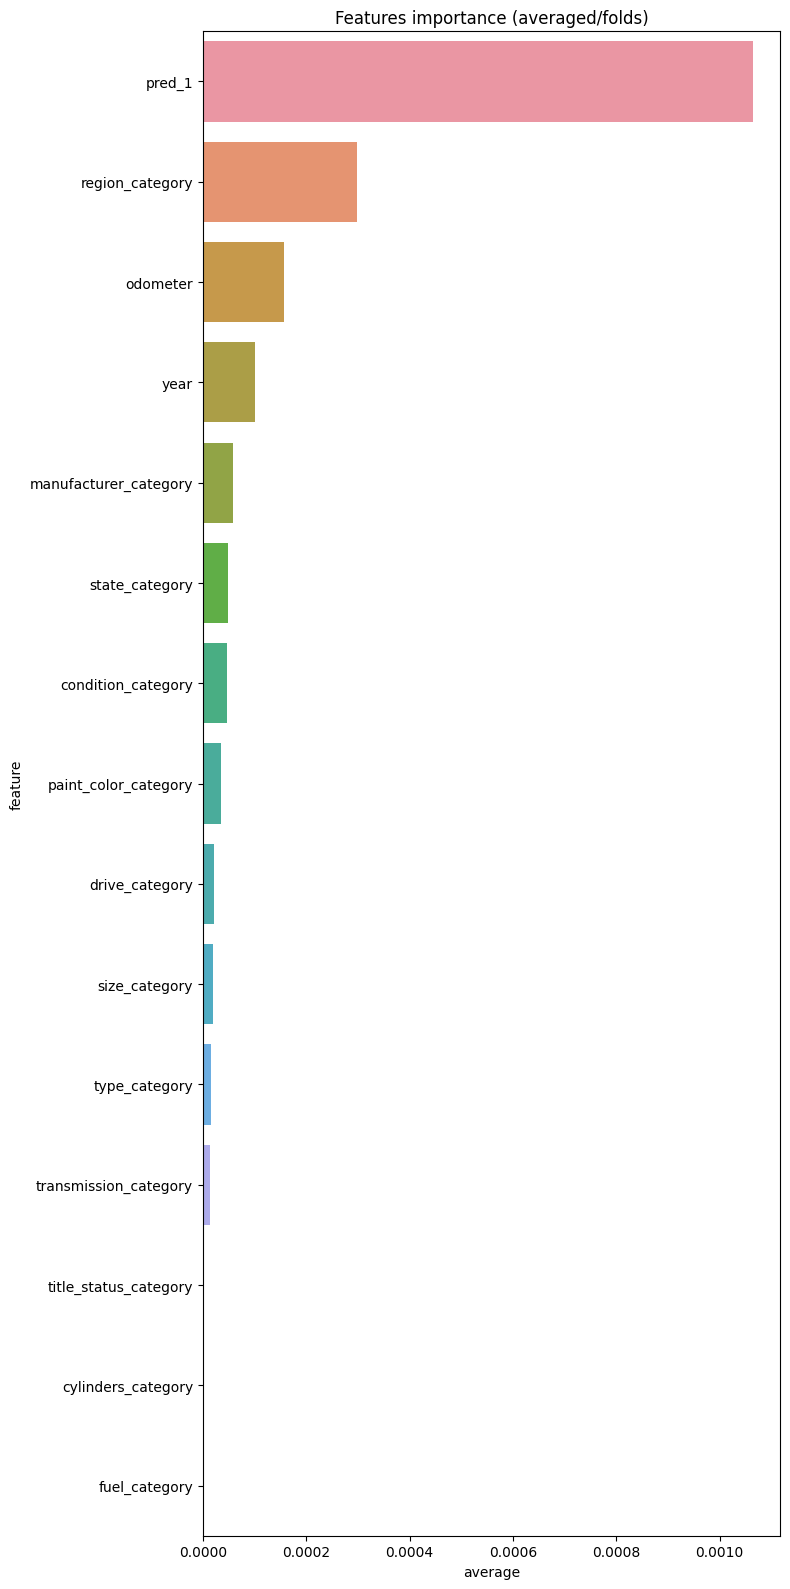

In [34]:
# ===================================================================
#  plot feature importance
# ===================================================================
feature_importance_df.fillna(value=0, inplace=True)
feature_importance_df["average"] = feature_importance_df.loc[:, 'importance_fold0':f'importance_fold{CFG.n_splits-1}'].mean(axis=1)
best_features = feature_importance_df[["feature", "average"]].groupby("feature", as_index=False).mean().sort_values(by="average", ascending=False).head(50)
plt.figure(figsize=(8, 16))
sns.barplot(x="average", y="feature", data=best_features)
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [33]:
# ===================================================================
#  optuna
# ===================================================================
def objective(trial):
    a = trial.suggest_float("a", 0, 1)
    
    oof_df[f"pred_1"] = oof_df[f"pred"] * a
    score = get_score(y_true=oof_df["price"], y_pred = oof_df[f"pred_1"])
    return score
    
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.TPESampler(seed=CFG.seed))
study.optimize(objective, 
                n_trials=CFG.n_trials,
                show_progress_bar=True)

best_params = study.best_params
best_value = study.best_value
print(best_params, best_value)

  0%|          | 0/1500 [00:00<?, ?it/s]

{'a': 0.9921007689303659} 45.807136662912896
